# 6. PSF modeling and subtraction with reference star differential imaging

> Author: *Valentin Christiaens*  
> Suitable for VIP *v1.0.3* onwards  
> Last update: *2024/06/04*

**Table of contents**

* [6.1. Loading ADI and RDI data](#6.1.-Loading-ADI-and-RDI-data)
* [6.2. Classical reference star differential imaging](#6.2.-Classical-RDI)
    - [6.2.1. median-RDI](#6.2.1.-median-RDI)
    - [6.2.2. PCA-RDI](#6.2.2.-PCA-RDI)
    - [6.2.3. PCA-ARDI](#6.2.3.-PCA-ARDI-(in-concentric-annuli))
    - [6.2.4. Contrast curves](#6.2.4.-Contrast-curves)
    - [6.2.5. NEGFC](#6.2.5.-NEGFC)
* [6.3. RDI for disk imaging](#6.3.-RDI-for-disk-imaging)
    - [6.3.1. PCA-RDI with data imputation](#6.3.1.-PCA-with-data-imputation)
    - [6.3.2. Iterative PCA](#6.3.2.-Iterative-PCA)

This tutorial shows:

- how to load ADI-ready datacubes; 
- how to use the stellar PSF subtraction algorithms implemented in VIP to produce final post-processed images, and leverage the RDI strategy;
- how to use iterative (greedy) algorithms in VIP to correct for geometric biases.

<div class="alert alert-block alert-info"> 
    <b>Note: </b>
<a class="anchor" id="note1"></a>

Most PSF subtraction routines in VIP (and some other functions) have been implemented in VIP to allow for **multiprocessing**, in order to optimally harness the power of machines equipped with multiple CPUs. Any function where the `nproc` parameter is available in its call can be run in multi-processing, with the value of `nproc` setting the requested number of CPUs to use. Instead of an integer, one can set `nproc=None` to use half of all available CPUs. For optimal results in multiprocessing, set the following environment parameters in your terminal **BEFORE** launching your Jupyter notebook:
    
`export MKL_NUM_THREADS=1`
    
`export NUMEXPR_NUM_THREADS=1`
    
`export OMP_NUM_THREADS=1`

In the case of PCA, singular value decomposition can also be done on **GPU** by setting `svd_mode` to an appropriate value (see [Sec. 3.5.1.](#3.5.1.-Full-frame-PCA) and docstrings of ``vip_hci.psfsub.pca`` for details).

</div>

Let's first import a couple of external packages needed in this tutorial:

In [1]:
%matplotlib inline
from hciplot import plot_frames, plot_cubes  # plotting routines
from matplotlib import pyplot as plt
from multiprocessing import cpu_count
import numpy as np
from packaging import version

In the following box we check that your version of VIP is recent enough.

In [2]:
import vip_hci as vip
vvip = vip.__version__
print("VIP version: ", vvip)
if version.parse(vvip) < version.parse("1.0.3"):
    msg = "Please upgrade your version of VIP"
    msg+= "It should be 1.0.3 or above to run this notebook."
    raise ValueError(msg)

VIP version:  1.6.2


## 6.1. Loading ADI data

In the 'dataset' folder of the `VIP_extras` repository you can find a toy ADI (Angular Differential Imaging) cube and a NACO point spread function (PSF) to demonstrate the capabilities of ``VIP``. This is an L'-band VLT/NACO  dataset of beta Pictoris published in [Absil et al. (2013)](https://ui.adsabs.harvard.edu/abs/2013A%26A...559L..12A/abstract) obtained using the Annular Groove Phase Mask (AGPM) Vortex coronagraph. The sequence has been heavily sub-sampled temporarily to make it smaller. The frames were also cropped to the central 101x101 area. In case you want to plug-in your cube just change the path of the following cells.

More info on this dataset, and on opening and visualizing fits files with VIP in general, is available in Tutorial `1. Quick start`.

Let's load the datacube, associated parallactic angles and non-coronagraphic PSF:

In [3]:
from vip_hci.fits import open_fits
from astropy.utils.data import download_file

url_d = "https://github.com/vortex-exoplanet/VIP_extras/raw/master/datasets"
f1 = download_file("{}/naco_betapic_cube_cen.fits".format(url_d), cache=True)
f2 = download_file("{}/naco_betapic_psf.fits".format(url_d), cache=True)
f3 = download_file("{}/naco_betapic_derot_angles.fits".format(url_d), cache=True)

# alternatively, for local files simply provide their full or relative path. E.g.:
#f1 = '../datasets/naco_betapic_cube_cen.fits'
#f2 = '../datasets/naco_betapic_psf.fits'
#f3 = '../datasets/naco_betapic_derot_angles.fits'

cube = open_fits(f1)
psf = open_fits(f2)
angs = open_fits(f3)

FITS HDU-0 data successfully loaded. Data shape: (61, 101, 101)
FITS HDU-0 data successfully loaded. Data shape: (39, 39)
FITS HDU-0 data successfully loaded. Data shape: (61,)


For the purpose of illustrating RDI capabilities in VIP, let's just define a fiducial reference cube as the science cube flipped along both the x and y axes.
Normally you should load it the same way as your science cube.

In [4]:
cube_ref = np.flip(cube, axis=1)       # just for the example
cube_ref = np.flip(cube_ref, axis=2)

Let's fit the PSF with a 2D Gaussian to infer the FWHM, the flux in a 1-FWHM size aperture, and get a flux-normalized PSF:

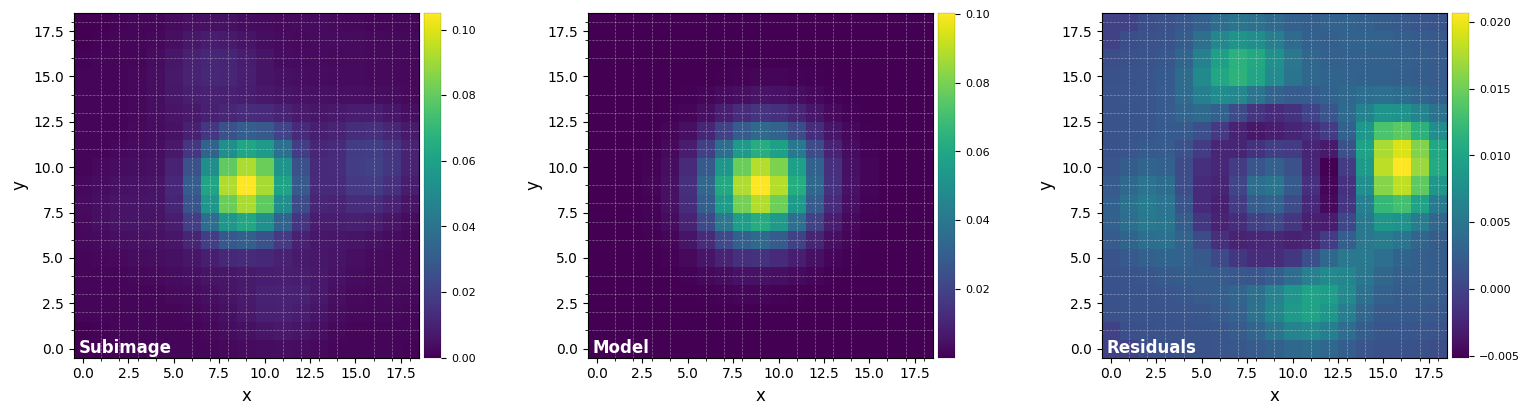

FWHM_y = 4.926059872957138
FWHM_x = 4.675778895005929 

centroid y = 9.010992107833063
centroid x = 9.01917912265807
centroid y subim = 9.010992107833063
centroid x subim = 9.01917912265807 

amplitude = 0.10032285220380603
theta = -38.446187060503874

Mean FWHM: 4.801
Flux in 1xFWHM aperture: 1.307


In [5]:
%matplotlib inline
from vip_hci.fm import normalize_psf
psfn, flux, fwhm_naco = normalize_psf(psf, size=19, debug=True, full_output=True)

In [6]:
print(fwhm_naco)

4.800919383981533


<div class="alert alert-block alert-info"> 
    <b>Note: </b>
<a class="anchor" id="note1"></a>

The `normalize_psf` function performs internally a fine centering of the PSF. The input PSF should nevertheless already be centered within a few pixel accuracy for the fine centering to work.
</div>

Let's visualize the normalized PSF with `hciplot.plot_frames`. Feel free to adapt the `backend` argument throughout the notebook: `'matplotlib'` (default) allows paper-quality figures with annotations which can be saved (default), while `'bokeh'` enables interactive visualization.

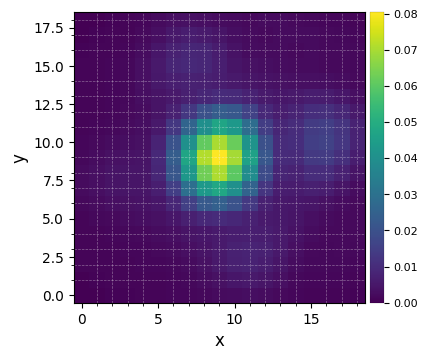

In [7]:
plot_frames(psfn, grid=True, size_factor=4)

Let's finally define the pixel scale for NACO (L' band), which we get from a dictionary stored in the `conf` subpackage:

In [8]:
from vip_hci.config import VLT_NACO
pxscale_naco = VLT_NACO['plsc']
print(pxscale_naco, "arcsec/px")

0.02719 arcsec/px


## 6.2. Classical RDI

### 6.2.1. median-RDI

The most straightforward way to leverage a stack of reference PSF images is to consider its median image as PSF model, and subtract it to each image of the science cube. This can be done with the `median_sub` function:

In [9]:
from vip_hci.psfsub import median_sub
med_rdi = median_sub(cube, angs, cube_ref=cube_ref)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-09-11 12:42:05
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:03.001939
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


Let's visualize the results, after masking the central 13 px of the image.

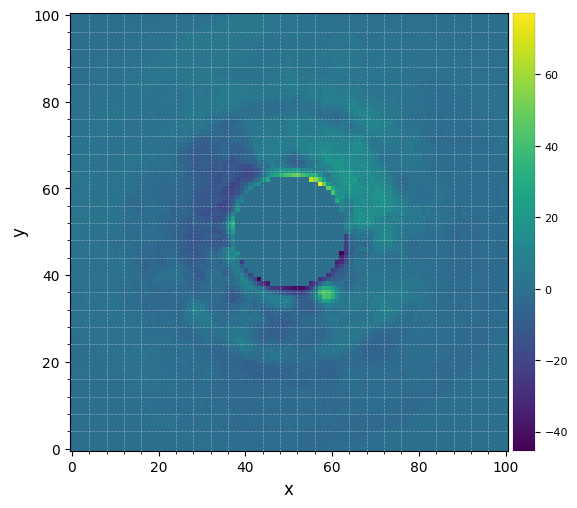

In [10]:
from vip_hci.var import mask_circle
plot_frames(mask_circle(med_rdi, 13), grid=True)

As can be seen above, this approach is sufficient to detect exoplanet beta Pic b towards the bottom right of the image (after masking the central part of the image)! This is not too bad, considering we only considered as fake reference cube the science images flipped horizontally and vertically.

The default behaviour will subtract the median reference image of the reference stack however other options can be used. Although the median is more robust, the mean of the reference stack can be requested instead:

In [11]:
mean_rdi = median_sub(cube, angs, cube_ref=cube_ref, collapse_ref='mean')

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-09-11 12:42:08
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:02.891387
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


Alternatively, the mean/median reference image can be scaled to match in flux each science image before subtraction - this can be useful if the reference image is known to be brighter or fainter than the science image:

In [12]:
med_rdi_sc = median_sub(cube, angs, cube_ref=cube_ref, collapse_ref='sc_median')

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-09-11 12:42:11
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:02.887784
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


By default when scaling is requested, the scaling factor is calculating from integrating the flux on the whole science and reference images. But an inner and outer radius can be provided, which can be relevant if a coronagraph is used or contamination is present at large radius, respectively. This is done by adding 2 numbers directly at the end of the ``collapse_ref`` string, separated by '-'. For example, if we want to consider an annulus going from 1 to 3 FWHM for this coronagraphic NaCo dataset (FWHM ~ 5pixels), we can set:

In [13]:
med_rdi_sc515 = median_sub(cube, angs, cube_ref=cube_ref, collapse_ref='sc_median5-15')

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-09-11 12:42:14
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:02.947804
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


Alternatively, median-RDI can be applied in concentric annuli with a scaling factor calculated per annulus. This is controlled with the ``mode`` argument (set to 'fullfr' by default). The width of the concentric annuli is set in pixels using argument `asize`, and the radius of the first annuli is set with ``radius_int``. Let's set both to the FWHM.

In [14]:
med_rdi_ann = median_sub(cube, angs, mode='annular', asize=fwhm_naco, radius_int=fwhm_naco,
                         cube_ref=cube_ref, collapse_ref='sc_median')

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-09-11 12:42:17
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 9, FWHM = 4
Processing annuli:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Optimized median psf reference subtracted
Done derotating and combining
Running time:  0:00:02.882723
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


Let's now visualize all the results obtained above, without any numerical mask:

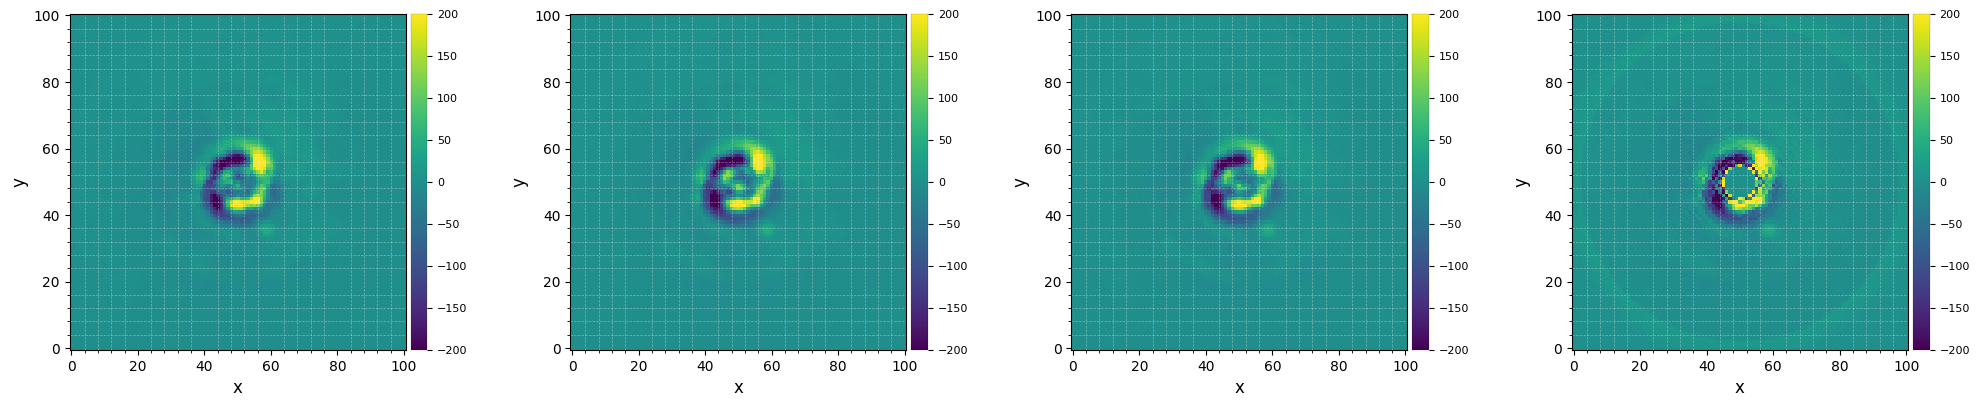

In [15]:
plot_frames((mean_rdi, med_rdi_sc, med_rdi_sc515, med_rdi_ann), vmin=-200, vmax=200, grid=True)

As expected the results obtained with the different ``collapse_ref`` options are very similar -- since here we used as fake reference cube the flipped science cube. We also notice strong residuals near the center of the image which shows the limitation of assuming a perfect centro-symmetry stellar halo. Nonetheless the signature of beta Pic b can be seen towards the bottom right of the image.

### 6.2.2. PCA-RDI

Using PCA leveraging the RDI strategy is as simple as calling the `pca` function in VIP with the `cube_ref` argument set to your cube of reference images. For example, to run PCA using 42 principal components:

In [16]:
from vip_hci.psfsub import pca
pca_rdi_fr = pca(cube, angs, ncomp=42, cube_ref=cube_ref)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-09-11 12:42:20
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 17.180 GB
System available memory = 3.246 GB
Done vectorizing the frames. Matrix shape: (61, 10201)
Done vectorizing the frames. Matrix shape: (61, 10201)
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:02.958566
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done de-rotating and combining
Running time:  0:00:05.964148
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


Let's visualize the results, after masking the central 13 px of the image.

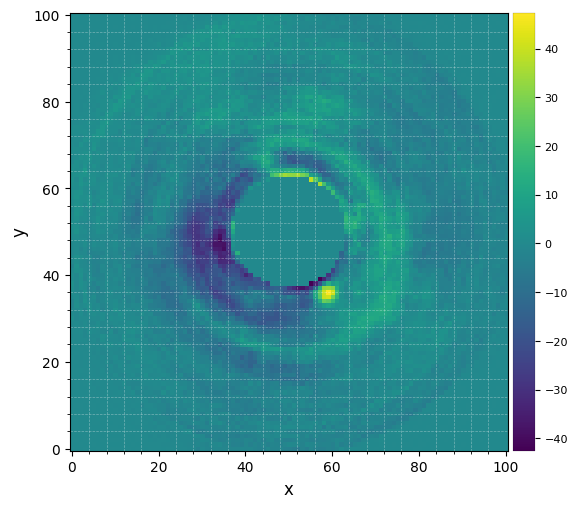

In [17]:
from vip_hci.var import mask_circle
plot_frames(mask_circle(pca_rdi_fr, 13), grid=True)

We now see Beta Pic b a bit clearer than with the median-subtraction approach.

A lot of options are available with the PCA function, and are also relevant with a reference cube. We refer to [Tutorial 3 (section 3.5)](https://vip.readthedocs.io/en/latest/tutorials/03A_psfsub_ADI.html#3.5.-Principal-Component-Analysis-(PCA)), for all available options. Below we just illustrate the use of a convenient function providing the SNR of a candidate as a function of number of principal components.

Let's first define the approximate coordinates of the companion based on the image above (remember to subtract 1 to the coordinates read in the image since Python uses a zero-based index system):

In [18]:
xy_b = (58, 35)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-09-11 12:42:27
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:02.188418
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Number of steps 51
Optimal number of PCs = 16, for S/N=3.633
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Coords of chosen px (X,Y) = 58.0, 35.0
Flux in a centered 1xFWHM circular aperture = 421.081
Central pixel S/N = 5.655
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Inside a centered 1xFWHM circular aperture:
Mean S/N (shifting the aperture center) = 3.633
Max S/N (shifting the aperture center) = 5.796
stddev S/N (shifting the aperture center) = 1.473



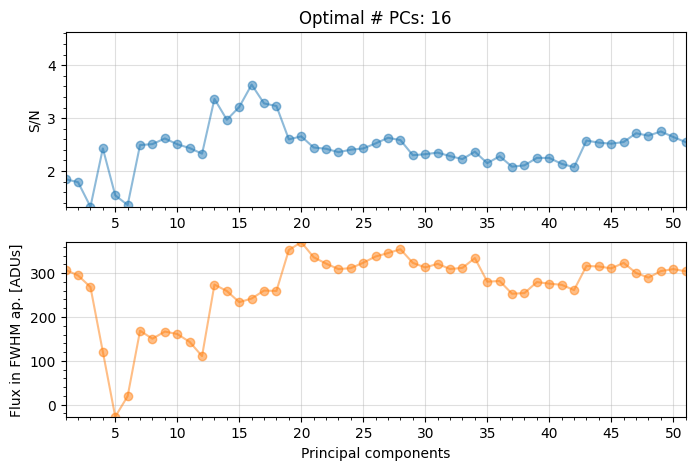

In [19]:
from vip_hci.psfsub import pca_grid
pca_rdi_opt = pca_grid(cube, angs, cube_ref=cube_ref, fwhm=fwhm_naco, range_pcs=(1,51,1),
                       source_xy=xy_b, mode='fullfr', full_output=True, plot=True)

In [20]:
pca?

Signature: pca(*all_args: List, **all_kwargs: dict)
Docstring:
Full-frame PCA algorithm applied to PSF substraction.

The reference PSF and the quasi-static speckle pattern are modeled using
Principal Component Analysis. Depending on the input parameters this PCA
function can work in ADI, RDI or mSDI (IFS data) mode.

ADI: the target ``cube`` itself is used to learn the PCs and to obtain a
low-rank approximation model PSF (star + speckles). Both `cube_ref`` and
``scale_list`` must be None. The full-frame ADI-PCA implementation is based
on [AMA12]_ and [SOU12]_. If ``batch`` is provided then the cube is
processed with incremental PCA as described in [GOM17]_.

(ADI+)RDI: if a reference cube is provided (``cube_ref``), its PCs are used
to reconstruct the target frames to obtain the model PSF (star + speckles).

(ADI+)mSDI (IFS data): if a scaling vector is provided (``scale_list``) and
the cube is a 4d array [# channels, # adi-frames, Y, X], it's assumed it
contains several multi-spectra

In [21]:
from vip_hci.config.paramenum import SvdMode
SvdMode?

Init signature:
SvdMode(
    value,
    names=None,
    *,
    module=None,
    qualname=None,
    type=None,
    start=1,
)
Docstring:     
Define the various modes to use with SVD in PCA as constant strings.

Modes
-----
* ``LAPACK``: uses the LAPACK linear algebra library through Numpy
and it is the most conventional way of computing the SVD
(deterministic result computed on CPU).

* ``ARPACK``: uses the ARPACK Fortran libraries accessible through
Scipy (computation on CPU).

* ``EIGEN``: computes the singular vectors through the
eigendecomposition of the covariance M.M' (computation on CPU).

* ``RANDSVD``: uses the randomized_svd algorithm implemented in
Sklearn (computation on CPU), proposed in [HAL09]_.

* ``CUPY``: uses the Cupy library for GPU computation of the SVD as in
the LAPACK version. `

* ``EIGENCUPY``: offers the same method as with the ``eigen`` option
but on GPU (through Cupy).

* ``RANDCUPY``: is an adaptation of the randomized_svd algorithm,
where all the computat

### 6.2.3. PCA-ARDI

One can also leverage *both* ADI and RDI in cases where there is enough field rotation in your science cube and an available cube of reference images - this is referred to as *ARDI*. PCA-ARDI is best done by calling the `pca_annular` function in VIP, with the `cube_ref` argument set to your cube of reference images -- although a trick can be done for a faster usage in full-frame (see below).

<div class="alert alert-block alert-info"> 
    <b>Note: </b>
<a class="anchor" id="note1"></a>

Mind the different **default** behaviours of the `pca` and `pca_annular` functions when provided a `cube_ref` reference cube. `pca` will adopt by default a RDI-only strategy (i.e., not use the science images to calculate the principal components), while `pca_annular` will *by default* follow an ARDI stratey (i.e., use both the reference images and the science images that meet a certain rotation threshold to calculate the principal components associated to each image of the cube). The latter approach is thus slower.
</div>

First let's consider two concentric annuli with respective width set to one quarter of the image size, using 13 principal components.

In [22]:
from vip_hci.psfsub import pca_annular
asize = cube.shape[-1]//4 - 1

pca_ardi_fr = pca_annular(cube, angs, ncomp=13, asize=asize, fwhm=fwhm_naco, cube_ref=cube_ref)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-09-11 12:45:20
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 2, FWHM = 4.801
PCA per annulus (or annular sectors):
Ann 1    PA thresh:  2.29    Ann center:  12    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:07:52.442157
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 2    PA thresh:  7.85    Ann center:  35    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:15:56.485911
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done derotating and combining.
Running time:  0:15:59.441470
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


Let's visualize the results, after masking the central 1 FWHM in the image.

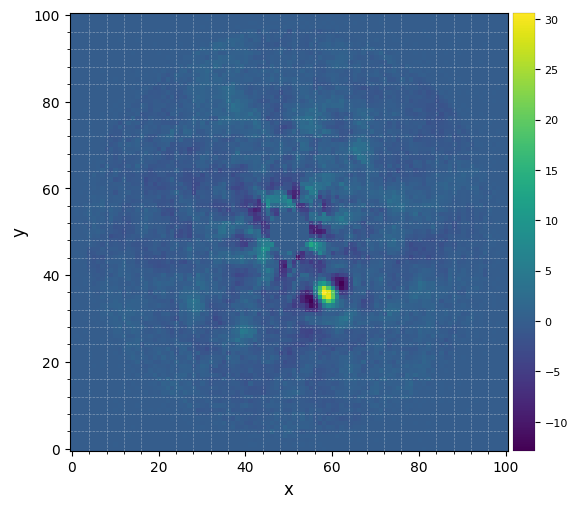

In [23]:
plot_frames(mask_circle(pca_ardi_fr, fwhm_naco), grid=True)

We now see Beta Pic b even clearer - with a result more similar to PCA-ADI ([tutorial 3 (section 3.5)](https://vip.readthedocs.io/en/latest/tutorials/03A_psfsub_ADI.html#3.5.-Principal-Component-Analysis-(PCA))).

By default, `pca_annular` uses both science and reference images for the PCA library, but the PCA library is recalculated for each image of the cube and for each concentric annulus (which is why it is much slower than full-frame `pca`). Only science images meeting a certain rotation threshold with respect to the considered image are considered for the associated PCA library. By default, the threshold is a minimum rotation of 0.1xFWHM for the innermost annulus, linearly increasing up to 1xFWHM for the outermost annulus. This behaviour is controlled with the `delta_rot` argument (set by default to (0.1, 1)). 

<div class="alert alert-block alert-info"> 
    <b>Note: </b>
<a class="anchor" id="note1"></a>

The `delta_rot` parameter is expressed in FWHM units, and corresponds to the amount of required linear motion (in pixels) at the middle of each concentric annulus. A single value, a tuple of 2 elements, or a list of `n_annuli` values, can be provided for that argument corresponding to: a single threshold in rotation to be used for all annuli, the lower and upper bounds of a linearly increasing rotation threshold, and the exact rotation threshold to be used for each of all concentric annuli, respectively.
</div>

Let's consider a few example cases - the most relevant choice for you will depend on your data:

* **ARDI** using all science and reference images in the PCA library, in 2 concentric annuli:

In [31]:
pca_ardi_all_fr = pca_annular(cube, angs, ncomp=13, asize=asize, cube_ref=cube_ref, delta_rot=0)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-09-11 14:07:13
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 2, FWHM = 4.000
PCA per annulus (or annular sectors):
Ann 1    Ann center:  12    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:08:07.345447
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 2    Ann center:  35    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:16:46.945749
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done derotating and combining.
Running time:  0:16:50.021504
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


* Pure **RDI** in 2 concentric annuli. This is done by setting `delta_rot` to an arbitrarily high value for no science image to meet the criterion for inclusion in the PCA library.

In [25]:
pca_rdi_ann_fr = pca_annular(cube, angs, ncomp=13, asize=asize, cube_ref=cube_ref, delta_rot=100)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-09-11 13:26:21
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 2, FWHM = 4.000
PCA per annulus (or annular sectors):
Ann 1    PA thresh: 173.13    Ann center:  12    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:02:34.106366
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 2    PA thresh: 160.15    Ann center:  35    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:05:16.320061
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done derotating and combining.
Running time:  0:05:19.488118
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


* **ARDI** in a single annulus, with a rotation threshold of 1 FWHM for inclusion of the science images to the PCA library:

In [26]:
asize1 = cube.shape[-1]//2 - 1
pca_ardi_thr1 = pca_annular(cube, angs, ncomp=13, asize=asize1, cube_ref=cube_ref, delta_rot=1)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-09-11 13:31:40
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 1, FWHM = 4.000
PCA per annulus (or annular sectors):
Ann 1    PA thresh:  9.73    Ann center:  24    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:06:54.914208
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done derotating and combining.
Running time:  0:06:57.950685
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


* **ARDI** in 4 concentric annuli, with a rotation threshold linearly increasing from 0.2 FWHM for the innermost annulus up to 1 FWHM for the outermost annulus:

In [27]:
asize4 = cube.shape[-1]//8 - 1
pca_ardi_ann4 = pca_annular(cube, angs, ncomp=13, asize=asize4, cube_ref=cube_ref, delta_rot=[0.1, 0.25, 0.5, 1])

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-09-11 13:38:38
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 4, FWHM = 4.000
PCA per annulus (or annular sectors):
Ann 1    PA thresh:  4.17    Ann center:   6    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:06:43.615960
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 2    PA thresh:  3.47    Ann center:  16    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:13:38.191523
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 3    PA thresh:  4.17    Ann center:  28    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:21:10.653297
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 4    PA thresh:  6.11    Ann center:  38    N segments: 1 
Done PCA with lapack for curre

* **ARDI** in full-frame considering all science and reference images (the **fastest** of all available options for ARDI). Here the trick is to redefine the reference cube to be a concatenation of the original science and reference cubes before passing it to the `pca` function:

In [28]:
cube_ref_tmp = np.concatenate((cube, cube_ref))
pca_ardi_full = pca(cube, angs, ncomp=13, cube_ref=cube_ref_tmp)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-09-11 14:06:59
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 17.180 GB
System available memory = 3.515 GB
Done vectorizing the frames. Matrix shape: (61, 10201)
Done vectorizing the frames. Matrix shape: (122, 10201)
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:09.125319
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done de-rotating and combining
Running time:  0:00:12.217991
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


<div class="alert alert-block alert-info"> 
    <b>Note: </b>
<a class="anchor" id="note1"></a>

If you run ARDI without any threshold in rotation on the science images, you may get very similar results to either ADI or RDI depending on the relative number of science and reference images in each cube, as the larger the stack the more it will dominate the principal components.
</div>

Let's visualize the results. For this, let's first place all the processed images in a numpy array, and mask the inner 10px of each image: 

In [29]:
pca_ardi_res = np.array((pca_ardi_fr, pca_ardi_all_fr, pca_rdi_ann_fr,
                         pca_ardi_thr1, pca_ardi_ann4, pca_ardi_full))
pca_ardi_res_mask = mask_circle(pca_ardi_res, 12)

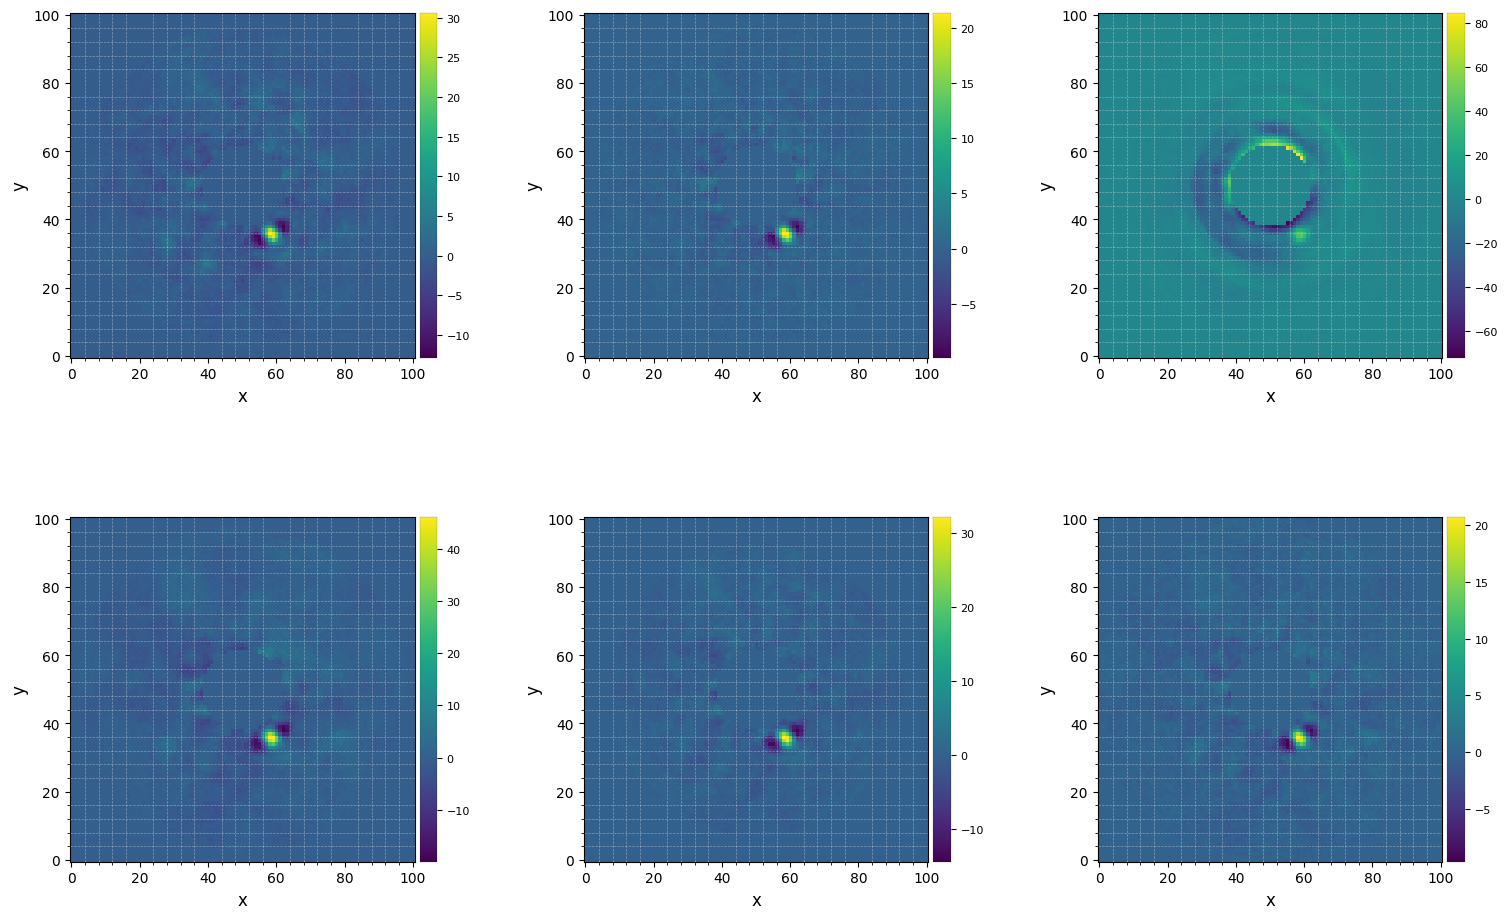

In [30]:
plot_frames(pca_ardi_res_mask, rows=2, grid=True)

Remember that the optimal strategy and relative weighting of science vs reference images will depend on the data at hand... Is a lot of field rotation available? Are the reference images well correlated to the science images? Do the radial profile of the reference and science PSF match?

### 6.2.4. Contrast curves

Let's now calculate and compare contrast curves obtained with PCA-ADI, PCA-RDI and PCA-ARDI for this dataset. For simplicity, we'll just consider a single set-up for each case in terms of number of principal components and rotation threshold.

Note that the correct way to do this is to first estimate the parameters of any companion (see [Tutorial 5A](https://vip.readthedocs.io/en/latest/tutorials/05A_fm_planets.html)) and remove the companion from the data. We quickly do this with the `cube_planet_free` function in the next cell, considering the parameters of beta Pic b reported in Absil et al. (2013).

In [14]:
from vip_hci.fm import cube_planet_free

r_b =  0.452/pxscale_naco # Absil et al. (2013)
theta_b = 211.2+90 # Absil et al. (2013)
f_b = 648.2

cube_emp = cube_planet_free([(r_b, theta_b, f_b)], cube, angs, psfn=psfn)

Among the parameters of the `contrast_curve` function, one needs to provide `starphot` which corresponds to the (expected) flux of the star in the coronagraphic images. The latter can be obtained from the non-coronagraphic PSF (e.g. through the `normalize_psf` function), and after rescaling this flux to the integration time ratio used for the coronagraphic vs non-coronagraphic observations. Let's assume here that this task was done separately:

In [15]:
starphot = flux # 764939.6

Another relevant parameter of the contrast curve function is ``algo``, which takes any function in ``VIP`` for model PSF subtraction, or a user-defined imported function. Optional parameters of the `algo` can also be passed as regular parameters of `contrast_curve`.

Let's now calculate the contrast curves: 

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-07-05 18:23:35
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
ALGO : pca, FWHM = 4.800919383981533, # BRANCHES = 3, SIGMA = 5, STARPHOT = 764939.6
Finished the throughput calculation
Running time:  0:00:19.781555
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-07-05 18:23:55
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
ALGO : pca, FWHM = 4.800919383981533, # BRANCHES = 3, SIGMA = 5, STARPHOT = 764939.6
Finished the throughput calculation
Running time:  0:00:20.264567
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


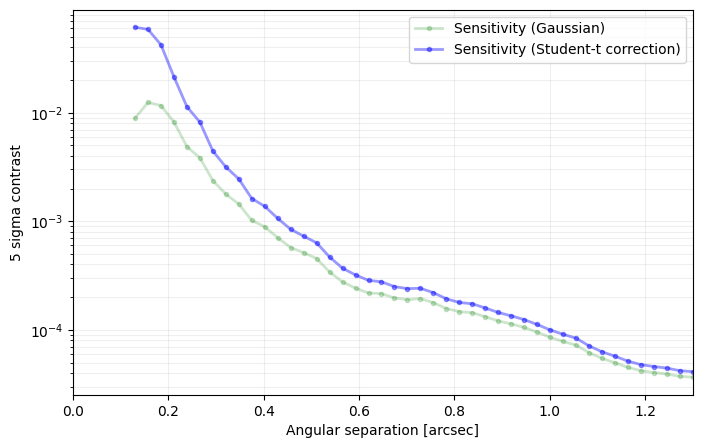

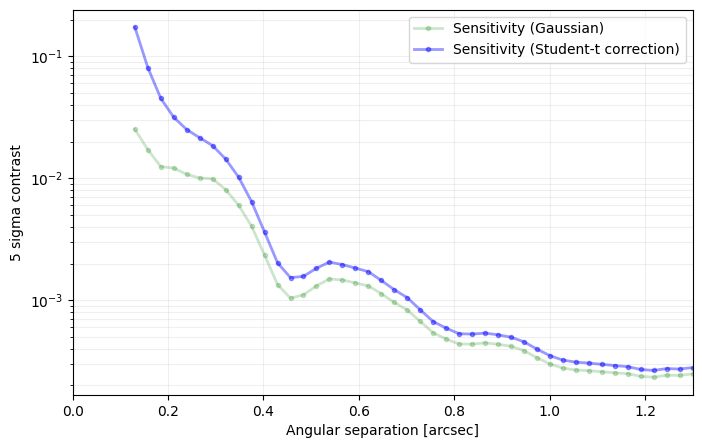

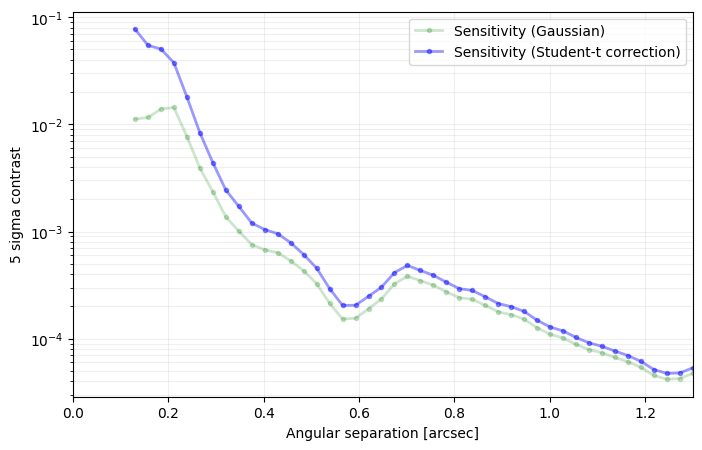

In [23]:
from vip_hci.metrics import contrast_curve
cc_adi = contrast_curve(cube_emp, angs, psfn, fwhm=fwhm_naco, pxscale=pxscale_naco, starphot=starphot, 
                        sigma=5, nbranch=3, algo=pca, ncomp=25)
cc_rdi = contrast_curve(cube_emp, angs, psfn, fwhm=fwhm_naco, pxscale=pxscale_naco, starphot=starphot, 
                        sigma=5, nbranch=3, algo=pca, ncomp=10, cube_ref=cube_ref)
cc_ardi = contrast_curve(cube_emp, angs, psfn, fwhm=fwhm_naco, pxscale=pxscale_naco, starphot=starphot, 
                         sigma=5, nbranch=3, algo=pca_annular, ncomp=20, cube_ref=cube_ref, asize=asize, delta_rot=0,
                         verbose=False)

Let's now compare the 3 contrast curves in a single plot, and also place Beta Pic b in the plot:

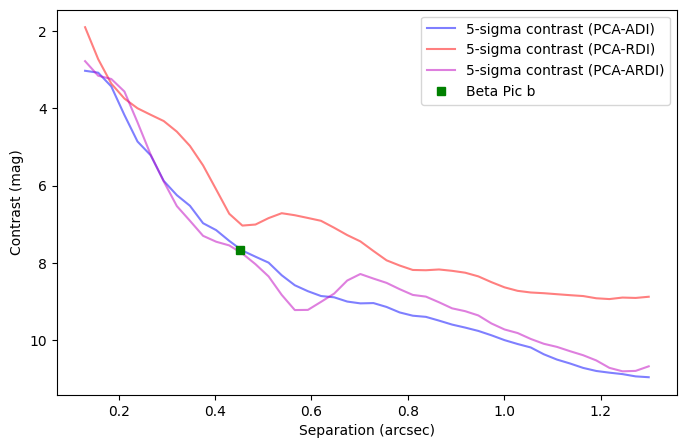

In [24]:
plt.figure(figsize=(8,5))
plt.plot(cc_adi['distance']*pxscale_naco, 
         -2.5*np.log10(cc_adi['sensitivity_student']), 
         'b-', label='5-sigma contrast (PCA-ADI)', alpha=0.5)
plt.plot(cc_rdi['distance']*pxscale_naco, 
         -2.5*np.log10(cc_rdi['sensitivity_student']), 
         'r-', label='5-sigma contrast (PCA-RDI)', alpha=0.5)
plt.plot(cc_ardi['distance']*pxscale_naco, 
         -2.5*np.log10(cc_ardi['sensitivity_student']), 
         'm-', label='5-sigma contrast (PCA-ARDI)', alpha=0.5)
plt.plot(r_b*pxscale_naco, 
         -2.5*np.log10(f_b/starphot), 'gs', label='Beta Pic b')
plt.gca().invert_yaxis()
plt.ylabel('Contrast (mag)')
plt.xlabel('Separation (arcsec)')
_ = plt.legend(loc='best')
plt.show()

Note that for well-correlated reference images (not the case here with our fake reference cube), the contrast achieved with PCA-RDI can become deeper than PCA-ADI at short separation, where little linear motion for field rotation is available.

Check out [tutorial 4](https://vip.readthedocs.io/en/latest/tutorials/04_metrics.html) for more examples of contrast curve calculations.

### 6.2.5. NEGFC

[Tutorial 5A](https://vip.readthedocs.io/en/latest/tutorials/05A_fm_planets.html) showcases in details how to use the NEGFC technique (combined with the ADI strategy) to estimate the position and flux of a directly imaged companion in your data. The typical workflow involves obtaining a first guess with a simplex algorithm, followed by using a MCMC algorithm for better estimates on the uncertainties on the parameters of the companion.

Below we just briefly illustrate how to use the NEGFC technique with the simplex (`firstguess`) algorithm for either RDI or ARDI strategies, but the same applies to the NEGFC algorithm.

First, let's inject a fake companion in the data:

In [25]:
from vip_hci.fm import cube_inject_companions
rad_fc = 30.5
theta_fc = 240
flux_fc = 400.
gt = [rad_fc, theta_fc, flux_fc]
cubefc = cube_inject_companions(cube, psf_template=psfn, angle_list=angs, flevel=flux_fc, plsc=pxscale_naco, 
                                rad_dists=[rad_fc], theta=theta_fc, n_branches=1)

In [26]:
from vip_hci.var import frame_center
cy, cx = frame_center(cube[0])
xy_test = cx+rad_fc*np.cos(np.deg2rad(theta_fc)), cy+rad_fc*np.sin(np.deg2rad(theta_fc))
xy_test

(34.749999999999986, 23.58622518457463)

#### 6.2.5.1. PCA-RDI

By default, the algorithm used by NEGFC is PCA in a single annulus (`pca_annulus`) encompassing the location of the companion. This function behaves in the same way as full-frame PCA when provided with a reference cube (i.e., it triggers pure RDI). The reference cube is provided through the `algo_options` argument, which allows to provide additional arguments associated to the algorithm:

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-07-05 18:25:11
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
             Planet 0           
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

Planet 0: flux estimation at the position [34.749999999999986,23.58622518457463], running ...
Step | flux    | chi2r
1/30   0.100   1.025
2/30   0.149   1.025
3/30   0.221   1.025
4/30   0.329   1.024
5/30   0.489   1.024
6/30   0.728   1.023
7/30   1.083   1.022
8/30   1.610   1.021
9/30   2.395   1.018
10/30   3.562   1.014
11/30   5.298   1.007
12/30   7.880   0.999
13/30   11.721   0.984
14/30   17.433   0.962
15/30   25.929   0.932
16/30   38.566   0.892
17/30   57.362   0.833
18/30   85.317   0.752
19/30   126.896   0.631
20/30   188.739   0.426
21/30   280.722   0.200
22/30   417.532   0.053


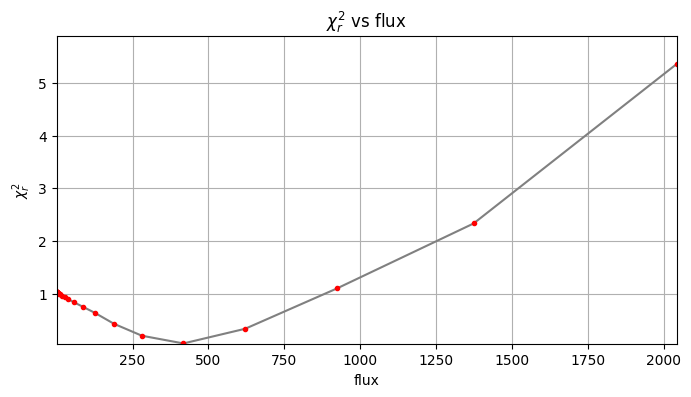

Planet 0: preliminary position guess: (r, theta)=(30.5, 240.0)
Planet 0: preliminary flux guess: 417.5
Planet 0: Simplex Nelder-Mead minimization, running ...
Planet 0: Success: True, nit: 105, nfev: 229, chi2r: 0.0510203564208559
message: Optimization terminated successfully.
Planet 0 simplex result: (r, theta, f)=(30.558, 239.944, 402.470) at 
          (X,Y)=(34.70, 23.55)

 ―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――― 
DONE !
 ――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running time:  0:00:49.165751
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [27]:
from vip_hci.fm import firstguess
r_rdi, theta_rdi, f_rdi = firstguess(cubefc, angs, psfn, ncomp=13, planets_xy_coord=[xy_test], 
                                     fwhm=fwhm_naco, f_range=None, annulus_width=4*fwhm_naco, 
                                     aperture_radius=2, simplex=True, plot=True,
                                     algo_options={'cube_ref':cube_ref}, verbose=True)

In [28]:
print("Ground truth injected parameters:", gt)
print("Estimated parameters by NEGFC (simplex):", [r_rdi[0], theta_rdi[0], f_rdi[0]])

Ground truth injected parameters: [30.5, 240, 400.0]
Estimated parameters by NEGFC (simplex): [30.558242070331474, 239.943979957012, 402.4698017374459]


#### 6.2.5.2. PCA-ARDI

To activate the ARDI strategy, one needs to use the `pca_annular` function (note the minor but important difference with `pca_annulus`). In this case, we also request a rotation threshold (`delta_rot`) to be 1 in the algorithm options dictionary.

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-07-05 18:26:00
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
             Planet 0           
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

Planet 0: flux estimation at the position [34.749999999999986,23.58622518457463], running ...
Step | flux    | chi2r
1/30   0.100   1.890
2/30   0.149   1.890
3/30   0.221   1.889
4/30   0.329   1.888
5/30   0.489   1.887
6/30   0.728   1.885
7/30   1.083   1.882
8/30   1.610   1.877
9/30   2.395   1.871
10/30   3.562   1.861
11/30   5.298   1.846
12/30   7.880   1.824
13/30   11.721   1.791
14/30   17.433   1.744
15/30   25.929   1.674
16/30   38.566   1.570
17/30   57.362   1.426
18/30   85.317   1.212
19/30   126.896   0.928
20/30   188.739   0.592
21/30   280.722   0.233
22/30   417.532   0.035


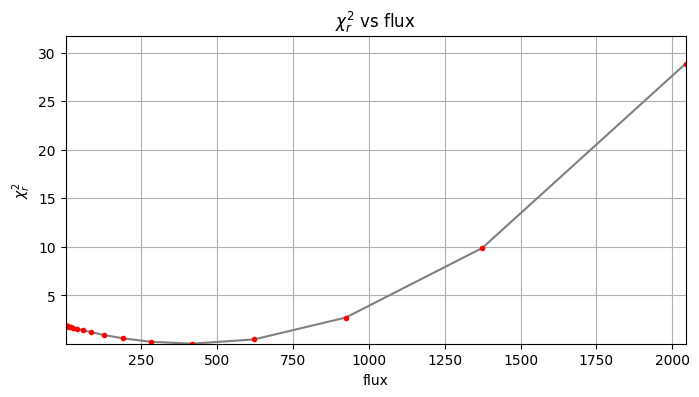

Planet 0: preliminary position guess: (r, theta)=(30.5, 240.0)
Planet 0: preliminary flux guess: 417.5
Planet 0: Simplex Nelder-Mead minimization, running ...
Planet 0: Success: True, nit: 85, nfev: 195, chi2r: 0.033955191901336564
message: Optimization terminated successfully.
Planet 0 simplex result: (r, theta, f)=(30.534, 240.161, 417.392) at 
          (X,Y)=(34.81, 23.51)

 ―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――― 
DONE !
 ――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running time:  0:01:39.080224
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [29]:
r_ardi, theta_ardi, f_ardi = firstguess(cubefc, angs, psfn, ncomp=13, planets_xy_coord=[xy_test], 
                                        fwhm=fwhm_naco, f_range=None, annulus_width=4*fwhm_naco, 
                                        aperture_radius=2, simplex=True, plot=True, algo=pca_annular,
                                        algo_options={'cube_ref':cube_ref, 'verbose':False,
                                                      'delta_rot':1}, 
                                        verbose=True)

In [30]:
print("Ground truth injected parameters:", gt)
print("Estimated parameters by NEGFC (simplex):", [r_ardi[0], theta_ardi[0], f_ardi[0]])

Ground truth injected parameters: [30.5, 240, 400.0]
Estimated parameters by NEGFC (simplex): [30.534119831048265, 240.16124692799315, 417.39168439970615]


## 6.3. RDI for disk imaging

### 6.3.1. PCA with data imputation

Now let's try the Principal Component Analysis (PCA)-based algorithms ([Amara & Quanz 2012](https://ui.adsabs.harvard.edu/abs/2012MNRAS.427..948A/abstract), [Soummer et al. 2012](https://ui.adsabs.harvard.edu/abs/2012ApJ...755L..28S/abstract)) in `vip.pca`.

We will more specifically use PCA-RDI with data imputation, as presented in [Ren (2023)](https://ui.adsabs.harvard.edu/abs/2023A%26A...679A..18R/abstract). We refer to that paper for the maths and nomenclature used in this section, including the concepts of anchor and boat masks. 

Let's first define a binary mask, with zeros covering the area of the image which could host circumstellar signals. Let's assume it covers the inner 20px radius:

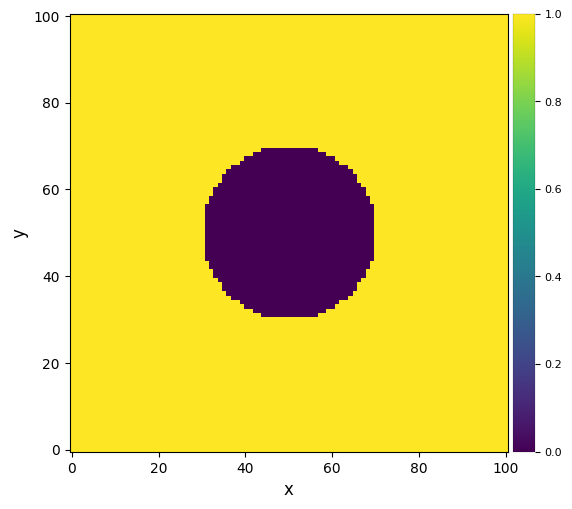

In [31]:
from vip_hci.var import mask_circle

anchor_mask = np.ones_like(cube[0])
anchor_mask = mask_circle(anchor_mask, 20)

plot_frames(anchor_mask)

Let's set to 30 the number of principal components `ncomp` considered for model creation, and let's run the PCA algorithm (feel free to test other values):

In [32]:
from vip_hci.psfsub import pca
ncomp = 30

mask_rdi1 = anchor_mask   # can be a 2D bool array

fr_pca_di1 = pca(cube, angs, ncomp=ncomp, cube_ref=cube_ref, mask_rdi=mask_rdi1, nproc=5)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-07-05 18:27:39
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 17.180 GB
System available memory = 3.793 GB
Done de-rotating and combining
Running time:  0:00:00.530680
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


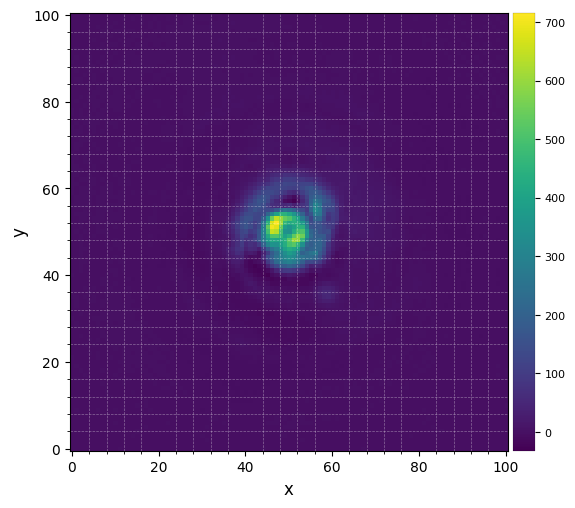

In [33]:
plot_frames(fr_pca_di1, grid=True)

There are strong residuals because the reference cube is not well correlated in this example.
A better approach would be to define 2 masks, anchor and boat masks, as in [Ren et al. (2023)](https://ui.adsabs.harvard.edu/abs/2023A%26A...679A..18R/abstract), where the boat mask only covers the relevant part of the field of view you are interested in (e.g. mask the IWA of the coronagraph or the areas too far out in the field).

In the case of a single mask as above, it is assumed to correspond to the anchor mask, and that the boat mask simply covers the full image.

Let's consider more sophisticated annular masks than above, and leverage the `get_annulus_segments` utility function in VIP:

In [34]:
from vip_hci.var import get_annulus_segments
get_annulus_segments?

Signature:
get_annulus_segments(
    data,
    inner_radius,
    width,
    nsegm=1,
    theta_init=0,
    optim_scale_fact=1,
    mode='ind',
    out=False,
)
Docstring:
Return indices or values in segments of a centered annulus.

The annulus is defined by ``inner_radius <= annulus < inner_radius+width``.

Parameters
----------
data : 2d numpy ndarray or tuple
    Input 2d array (image) ot tuple with its shape.
inner_radius : float
    The inner radius of the donut region.
width : float
    The size of the annulus.
nsegm : int
    Number of segments of annulus to be extracted.
theta_init : int
    Initial azimuth [degrees] of the first segment, counting from the
    positive x-axis counterclockwise.
optim_scale_fact : float
    To enlarge the width of the segments, which can then be used as
    optimization segments (e.g. in LOCI).
mode : {'ind', 'val', 'mask'}, optional
    Controls what is returned: indices of selected pixels, values of
    selected pixels, or a boolean mask.
out : 

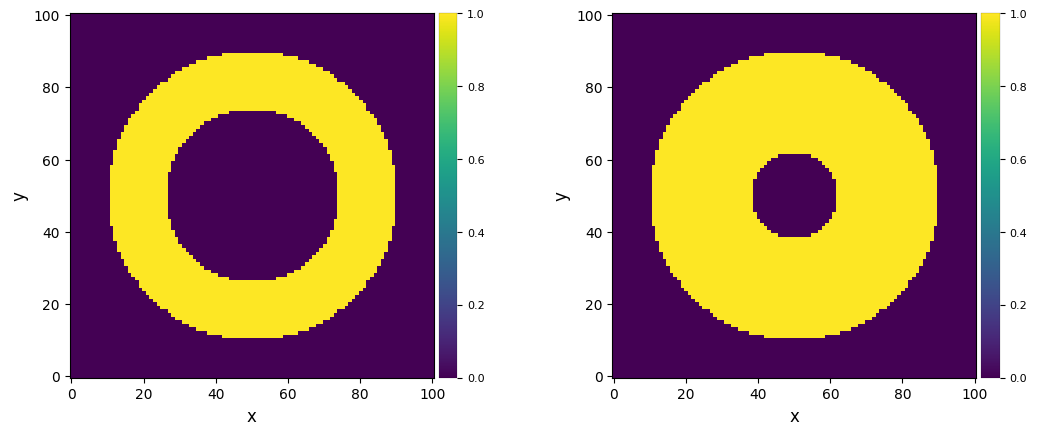

In [35]:
coro = 12    # discard signal within ~IWA of coronagraphic mask
ring_in = 24
ring_out = 40

ones = np.ones_like(cube[0])
anchor_mask = get_annulus_segments(ones, ring_in, ring_out-ring_in, mode="mask")[0]
boat_mask = get_annulus_segments(ones, coro, ring_out-coro, mode="mask")[0]

plot_frames((anchor_mask, boat_mask))

In [36]:
from vip_hci.psfsub import pca
ncomp = 30

mask_rdi2 = (anchor_mask, boat_mask)   # can be a tuple of 2 2D bool array

fr_pca_di2 = pca(cube, angs, ncomp=ncomp, cube_ref=cube_ref, mask_rdi=mask_rdi2)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-07-05 18:27:40
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 17.180 GB
System available memory = 3.964 GB
Done de-rotating and combining
Running time:  0:00:02.099145
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


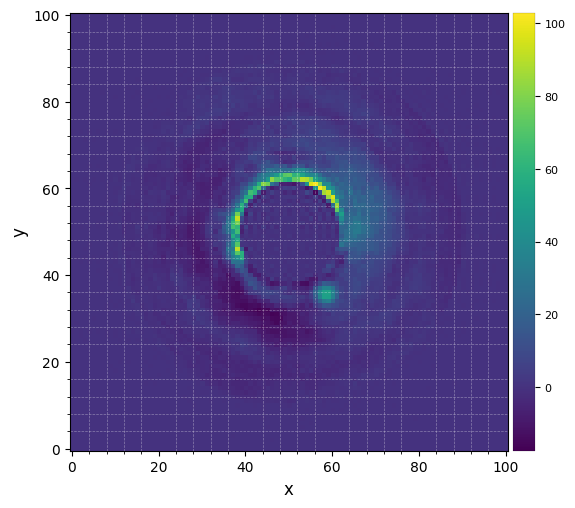

In [37]:
plot_frames(fr_pca_di2, grid=True)

### 6.3.2. Iterative PCA

**IPCA-ADI**

In [38]:
from vip_hci.greedy import ipca

fr_ipca_ADI = ipca(cube=cube, angle_list=angs, ncomp=15, nit=20)

Iterating...
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:02:28


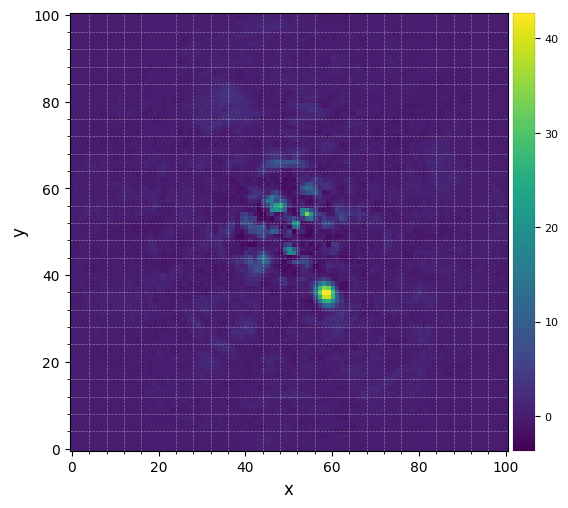

In [39]:
%matplotlib inline
plot_frames(fr_ipca_ADI, grid=True)

To check more outputs, including the cube of images obtained at each iteration, it's a matter of setting `full_output=True`:

In [40]:
from vip_hci.greedy import ipca

res_ipca_ADI = ipca(cube=cube, angle_list=angs, ncomp=15, nit=20, full_output=True)

Iterating...
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:03:01


In [41]:
fr_ipca, it_cube, sig_images, residuals_cube, residuals_cube_, stim_cube, it_cube_nd = res_ipca_ADI

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

:Dataset   [x,y,time]   (flux)
:Cube_shape	[101, 101, 20]


:DynamicMap   [time]
   :Image   [x,y]   (flux)
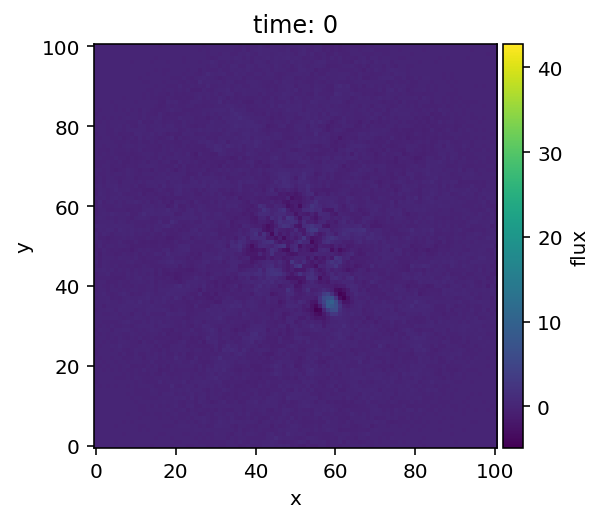

In [42]:
plot_cubes(it_cube, grid=True)

**IPCA-ARDI** (recommended)

For all cases above, and this one below, the number of PCs is constant, and the number of iterations set by `nit`.

In [43]:
from vip_hci.greedy import ipca

res_ipca_ARDI = ipca(cube=cube, angle_list=angs, ncomp=15, nit=20, cube_ref=cube_ref, strategy='ARDI', full_output=True)


Iterating...
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:05:00


In [44]:
fr_ipca_ARDI, it_cube_ARDI, sig_images, residuals_cube, residuals_cube_, stim_cube, it_cube_nd = res_ipca_ARDI

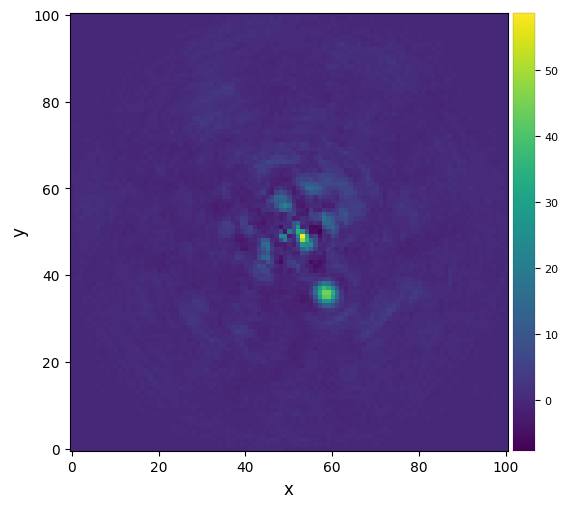

In [45]:
%matplotlib inline
plot_frames(fr_ipca_ARDI)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

:Dataset   [x,y,time]   (flux)
:Cube_shape	[101, 101, 20]


:DynamicMap   [time]
   :Image   [x,y]   (flux)
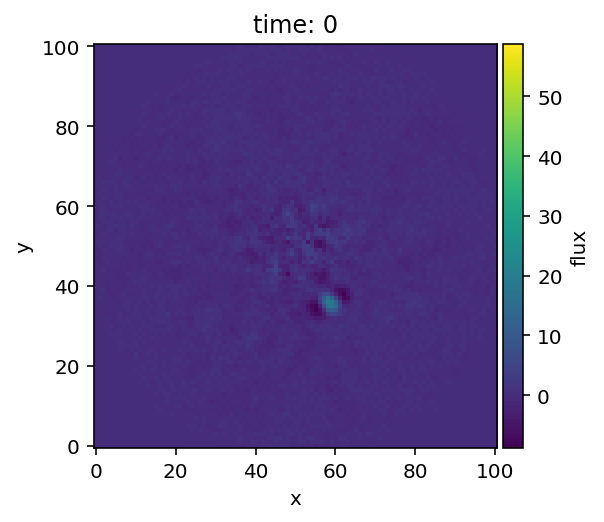

In [46]:
plot_cubes(it_cube_ARDI, grid=True)

It is possible to increase the number of PCs with the iterations by setting `mode='Pairet21'`, in this case `ncomp` is the final number of PCs at the last iteration, and `nit` is the number of iterations with each tested number of PCs:

In [47]:
from vip_hci.greedy import ipca

res_ipca_ARDI_incr = ipca(cube=cube, angle_list=angs, ncomp=30, nit=5, cube_ref=cube_ref, strategy='ARDI', 
                          mode='Pairet21', full_output=True)


Iterating...
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:31:21


In [48]:
fr_ipca_ARDI_incr, it_cube_ARDI_incr, sig_images, residuals_cube, residuals_cube_, stim_cube, it_cube_nd = res_ipca_ARDI_incr

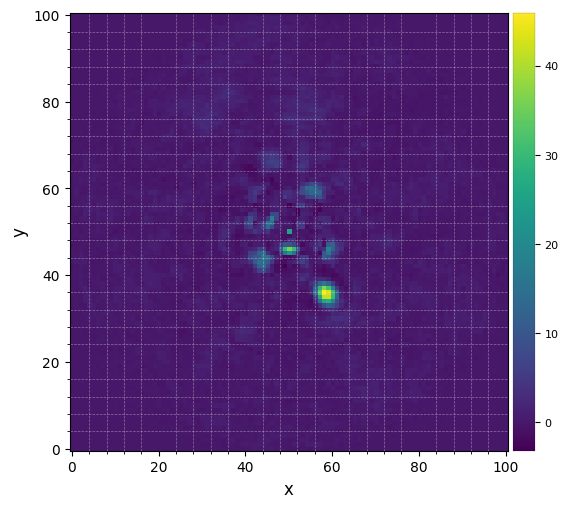

In [49]:
%matplotlib inline
plot_frames(fr_ipca_ARDI_incr, grid=True)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

:Dataset   [x,y,time]   (flux)
:Cube_shape	[101, 101, 150]


:DynamicMap   [time]
   :Image   [x,y]   (flux)
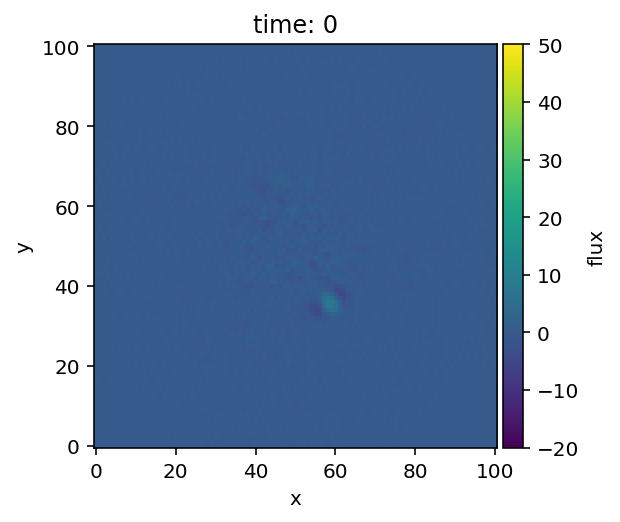

In [50]:
plot_cubes(it_cube_ARDI_incr, grid=True, vmin=-20, vmax=50)

**IPCA-ARDI** with data imputation at the first iteration (not yet much tested, but possibly even better than regular IPCA-ARDI)

In [51]:
from vip_hci.greedy import ipca

res_ipca_ARDI_di = ipca(cube=cube, angle_list=angs, ncomp=30, nit=42, cube_ref=cube_ref,
                        strategy='ARDI', mask_rdi=mask_rdi2, full_output=True)


Iterating...
0% [##########################    ] 100% | ETA: 00:00:48Final Convergence criterion met after 37 iterations


An internal criterion of convergence exists, and if met the algorithm can stop earlier than the requested number of iterations. The convergence criterion can be adapted with arguments `rtol` and `atol`, the relative and absolute tolerance, respectively, which concerns the difference between the images of 2 consecutive iterations.

In [52]:
fr_ipca_ARDI_di, it_cube_ARDI_di, sig_images, residuals_cube, residuals_cube_, stim_cube, it_cube_nd = res_ipca_ARDI_di

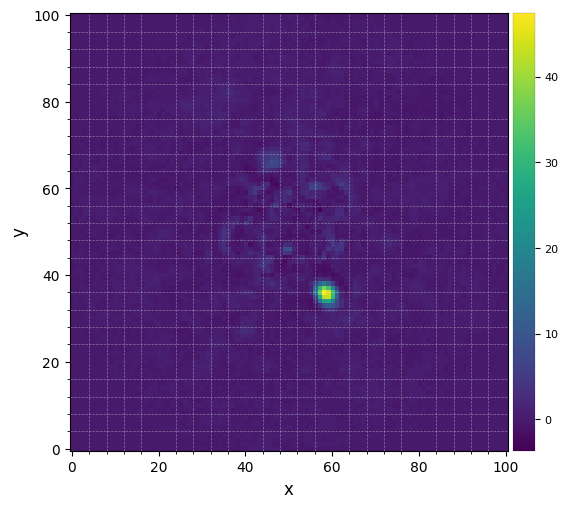

In [53]:
%matplotlib inline
plot_frames(fr_ipca_ARDI_di, grid=True)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

:Dataset   [x,y,time]   (flux)
:Cube_shape	[101, 101, 38]


:DynamicMap   [time]
   :Image   [x,y]   (flux)
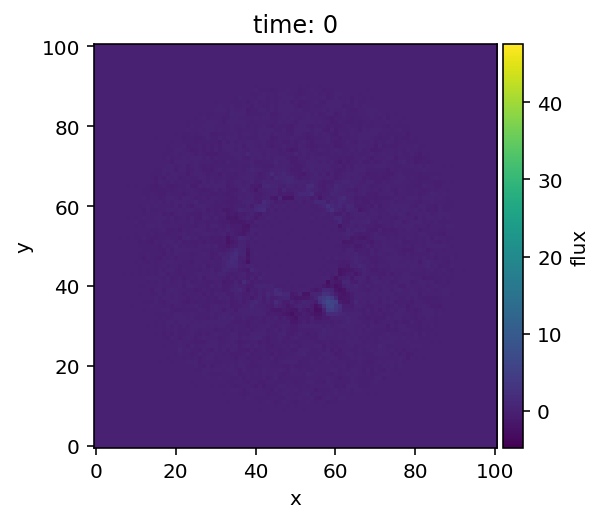

In [54]:
plot_cubes(it_cube_ARDI_di, grid=True)